### Author: Charlie Moffett, NYU CUSP, 2017

This is a simple spatial exploratory analysis of census data. 

The goal is to assess whether LinkNYC access point locations are optimal to guarantee a more "democratic" access to the internet.

In [232]:
from __future__ import print_function, division
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import io
import shapely
import pylab as pl
%pylab inline

from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. PUMA : Public Use Microdata Area

In [233]:
# download the NYC PUMA geometry fron the NYC Open Data API and read it in with geopandas
# from https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty/data

#url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
#urllib.urlretrieve(url, "puma.zip")

In [234]:
# unpack the data into my PUIdata directory
# os.system('unzip -d %s puma.zip'%(os.getenv('PUIDATA')))

In [235]:
# read in shapefile with geopandas
filename = 'geo_export_0472869f-1837-47ee-9564-3fc8590e7fbc.shp'
pumashp = gpd.GeoDataFrame.from_file(os.getenv('PUIDATA') + '/geo_export_0472869f-1837-47ee-9564-3fc8590e7fbc.shp')

pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [236]:
pumashp.crs

{'init': 'epsg:4326'}


Title: PUMA regions in New York City


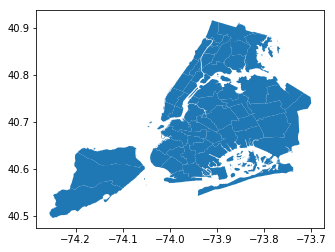

In [237]:
# plot the PUMA NYC regions

pumashp.plot()
print("\nTitle: PUMA regions in New York City")

__Figure 1: This map of New York City displays the contours of the PUMA regions. PUMAs are geographical areas designed to aggregate census data. Each PUMA contains at least 100,000 people. PUMAs do not overlap, and are contained within a single state.__

# 2. American FactFinder data on % of houses w/ broadband internet access

In [238]:
#reading in my api key saved in censusAPI.py as
#myAPI = 'XXXXXXXXXXXXXXX'
import censusAPI
import requests

In [239]:
# Download the table of data from 2016 for NYC

url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [240]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))

I need two features: total number of households, and number of households with broadband access

In [241]:
#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_007MA',
  'Annotation of Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_007M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_004M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband of any type'),
 ('B28002_008M',
  'Margin of Error!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_008EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_007EA',
  'Annotation of Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber opti

In [242]:
#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [243]:
# choose the fractions of houses with any "With an Internet subscription!!Broadband of any type"
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int',
 'validValues': []}

In [245]:
key = open(os.getenv('PUIDATA') + '/myAPI.txt', 'r')
myAPI = key.readline()

In [246]:
# getting the broadband access number of households
# replace API key with env var before pushing
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.tail()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
140,50844,"NYC-Queens Community District 5--Ridgewood, Gl...",36,4110,NaN
141,37570,NYC-Queens Community District 9--Richmond Hill...,36,4111,NaN
142,54603,"NYC-Queens Community District 12--Jamaica, Hol...",36,4112,NaN
143,32506,NYC-Queens Community District 10--Howard Beach...,36,4113,NaN
144,32172,NYC-Queens Community District 14--Far Rockaway...,36,4114,NaN


In [247]:
#getting the first row of the table: the total number of households
url2 = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp2 = requests.request('GET', url2).content
pumaPP = pd.read_csv(io.StringIO(resp2.decode('utf-8').replace('[','').replace(']','')))

pumaPP.tail()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
140,61570,"NYC-Queens Community District 5--Ridgewood, Gl...",36,4110,NaN
141,44811,NYC-Queens Community District 9--Richmond Hill...,36,4111,NaN
142,71109,"NYC-Queens Community District 12--Jamaica, Hol...",36,4112,NaN
143,37998,NYC-Queens Community District 10--Howard Beach...,36,4113,NaN
144,41368,NYC-Queens Community District 14--Far Rockaway...,36,4114,NaN


In [248]:
# generate a feature for the percentage of households with broadband access
pumaBB['pcBB'] = (pumaBB.B28002_004E / pumaPP.B28002_001E) * 100
pumaBB['pcBB'] = pumaBB.pcBB.astype(int)

In [249]:
#pumaBB.pcBB

In [250]:
# compare it with the AFF published "percentage of households with broadband access"
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,1,74.7,0.5
1,100100,70.9,2.5
2,100200,80.5,2.7
3,100301,87.0,2.8
4,100302,81.9,2.9


In [63]:
bbpc.columns

Index(['GCT_STUB.target-geo-id2', 'HC01', 'HC02'], dtype='object')

In [64]:
bbpc['gid'] = bbpc[['GCT_STUB.target-geo-id2']].astype(int)

In [65]:
type(bbpc.gid[1])

numpy.int64

In [66]:
bbpc["gid"] = bbpc.gid - 100000

In [67]:
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
0,1,74.7,0.5,-99999
1,100100,70.9,2.5,100
2,100200,80.5,2.7,200
3,100301,87.0,2.8,301
4,100302,81.9,2.9,302


In [68]:
type(pumaBB.pcBB[1])

numpy.int64

In [69]:
# checking that the percentage of households with broadband I generated, 
# and the one I read in from the table I downloaded manually, 
# are the same
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()

,pcBB,HC01,diff
count,17.000000,17.000000,17.000000
mean,79.647059,73.094118,7.964706
std,4.471314,6.834789,7.743380
min,73.000000,58.400000,0.300000
25%,75.000000,70.100000,2.000000
50%,80.000000,74.700000,5.500000
75%,84.000000,77.200000,11.900000
max,87.000000,82.300000,26.200000


In [70]:
diff_.head()

,pcBB,HC01,diff
0,80,70.9,9.1
1,75,80.5,5.5
2,81,81.3,0.3
3,84,68.6,15.4
4,81,74.7,6.3


# 3 Plot a choropleth of NYC broadband access

In [71]:
pumashp.head()

,puma,shape_leng,shape_area,geometry
0,3701,53227.144376,9.792852e+07,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,106050.008344,1.889860e+08,POLYGON ((-73.86477258283533 40.90201244187379...
2,3703,304875.033427,2.670770e+08,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,47970.900868,1.062129e+08,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,3705,68593.066759,1.224946e+08,POLYGON ((-73.87045508990893 40.86663286876232...


In [72]:
pumashp.columns

Index(['puma', 'shape_leng', 'shape_area', 'geometry'], dtype='object')

In [76]:
pumaBB.columns

Index(['B28002_004E', 'NAME', 'state', 'public use microdata area',
       'Unnamed: 4', 'pcBB'],
      dtype='object')

In [91]:
pumaBB['public use microdata area'] = pumaBB['public use microdata area'].astype(int)
pumashp['puma'] = pumashp.puma.astype(int)

In [92]:
# Merge with the PUMA geodataframe

pumashp_new = pumashp.merge(pumaBB, right_on="public use microdata area", 
                     left_on="puma")

In [93]:
pumashp_new.shape

(55, 10)

In [96]:
pumashp_new.columns

Index(['puma', 'shape_leng', 'shape_area', 'geometry', 'B28002_004E', 'NAME',
       'state', 'public use microdata area', 'Unnamed: 4', 'pcBB'],
      dtype='object')


Title: Percentage of Household in NYC with Broadband Access by PUMA


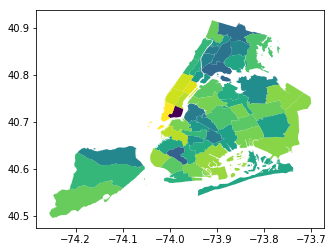

In [146]:
# Plot a choropleth of the percentage of households with broadband access
pumashp_new.plot(column='pcBB')
print("\nTitle: Percentage of Household in NYC with Broadband Access by PUMA")

__Figure 2: This map shows the number of households in each Public Use Micro Area (as defined by the US Census Bureau) divided by the total number of households in each PUMA region - expressed as a percentage. The lighter regions (up to bright yellow) are PUMA regions with higher percentages of households with broadband internet subscriptions. The darker regions have lower rates of broadband access.__

# 4. LinkNYC: assess whether the station locations are well distributed

In [102]:
# acquire the linkNYC locations and prepare them into a dataframe
linkNYC = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2017_fb55/master/HW9_fb55/linkNYClocations.csv')

In [103]:
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [104]:
linkNYC.shape

(1414, 5)

In [110]:
# combine long lat into a column
linkNYC.dropna(axis=0, subset=['latitude','longitude'], inplace=True)
linkNYC['lonlat']=list(zip(linkNYC.longitude, linkNYC.latitude))

In [111]:
# convert the dataframe into a GeoDataFrame 'linkNYC' and set native coordinates frame to lat/lon
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [112]:
noisegdf = gpd.GeoDataFrame(linkNYC)
noisegdf.crs = {'init': 'epsg:4326'} ## noisegdf did not have a defined crs, 
                                     # but it is clearly in 4326: lat/lon
noisegdf.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)



Title: LinkNYC Stations over Broadband Access Percentage


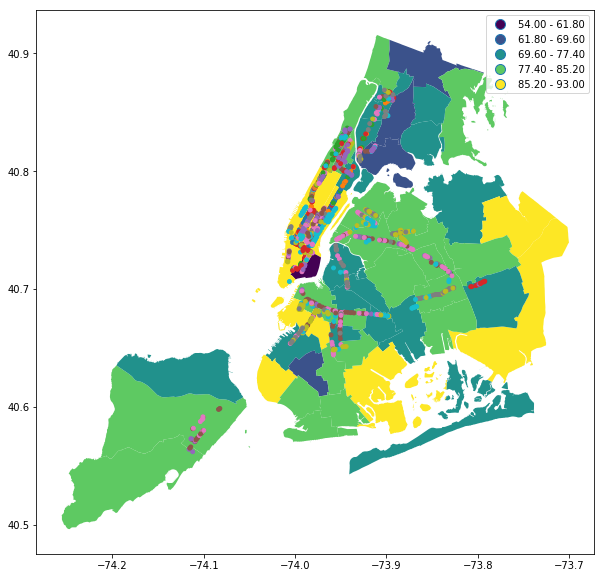

In [147]:
# plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals
f, ax = plt.subplots(figsize=(10,10))

base = pumashp_new.plot(ax=ax, column = 'pcBB', k=5, scheme='equal_interval', legend=True)
noisegdf.plot(ax=ax, markersize=15, column = 'date_link_')

print("\nTitle: LinkNYC Stations over Broadband Access Percentage")

__Figure 3: Basemap here is the same as Figure 2, except that now we've bucketed our percentages of household broadband access into five equal intervals. On top, we've plotted the locations of LinkNYC stations, color coded by how long ago each was installed.__

# 5. Find the number of LinkNYC locations per person by PUMA

In [199]:
#keyword for the number of total population
keyNpop = 'B00001_001E'

In [200]:
# Grabbing the total population by puma and merge it into my GeoDF
url3 = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNpop +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp3 = requests.request('GET', url3).content
pumaPop = pd.read_csv(io.StringIO(resp3.decode('utf-8').replace('[','').replace(']','')))

pumaPop.head()

,B00001_001E,NAME,state,public use microdata area,Unnamed: 4
0,3075,"St. Lawrence County PUMA, New York",36,100,NaN
1,4356,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,2736,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,2722,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,2874,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [215]:
pumaPop.shape

(145, 5)

In [201]:
# convert both pumashp and linkNYC to flat coordinate plane systems
puma_ft = pumashp_new.to_crs(epsg=2263)
linkNYC_ft = noisegdf.to_crs(epsg=2263)

In [202]:
type(pumaPop['public use microdata area'][1])

numpy.int64

In [203]:
puma_ft.columns

Index(['puma', 'shape_leng', 'shape_area', 'geometry', 'B28002_004E', 'NAME',
       'state', 'public use microdata area', 'Unnamed: 4', 'pcBB'],
      dtype='object')

In [204]:
# create a geodataframe with a spatial join
# use groupby to count the number of linkNYC in each PUMA
linkpp = gpd.sjoin(puma_ft, linkNYC_ft, op='intersects').groupby('puma').count().reset_index()[["puma", "link_site"]]

linkpp.head()

,puma,link_site
0,3701,1
1,3705,1
2,3706,20
3,3707,29
4,3708,19


In [205]:
# find the number of stations per 100 people per PUMA
linkNYC_combo = puma_ft.merge(linkpp, how='outer')
linkNYC_combo.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,pcBB,link_site
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,84,1.0
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,68,NaN
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,82,NaN
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,72,NaN
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,69,1.0


In [206]:
linkNYC_combo.shape

(55, 11)

In [208]:
pumaPop.columns

Index(['B00001_001E', 'NAME', 'state', 'public use microdata area',
       'Unnamed: 4'],
      dtype='object')

In [209]:
final_merge = linkNYC_combo.merge(pumaPop)
final_merge.shape

(55, 12)

In [210]:
final_merge.columns

Index(['puma', 'shape_leng', 'shape_area', 'geometry', 'B28002_004E', 'NAME',
       'state', 'public use microdata area', 'Unnamed: 4', 'pcBB', 'link_site',
       'B00001_001E'],
      dtype='object')

In [211]:
final_merge.head()

,puma,shape_leng,shape_area,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,pcBB,link_site,B00001_001E
0,3701,53227.144376,9.792852e+07,"POLYGON ((1012885.033996583 268830.4841918442,...",35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,84,1.0,1517
1,3702,106050.008344,1.889860e+08,"POLYGON ((1021632.335632326 267934.4393920284,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,68,NaN,1959
2,3703,304875.033427,2.670770e+08,(POLYGON ((1042822.450195312 243439.8142089319...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,82,NaN,1305
3,3704,47970.900868,1.062129e+08,"POLYGON ((1026308.769592285 256767.6972045382,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,72,NaN,1882
4,3705,68593.066759,1.224946e+08,"POLYGON ((1020080.524597168 255041.8771972096,...",40757,"NYC-Bronx Community District 3 & 6--Belmont, C...",36,3705,NaN,69,1.0,2011


In [212]:
final_merge["linkNYCp100p"] = (final_merge.link_site / final_merge.B00001_001E) * 100

In [213]:
final_merge["linkNYCp100p"].describe()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3403: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


count    37.000000
mean      2.327677
std       3.328955
min       0.049727
25%            NaN
50%            NaN
75%            NaN
max      15.141540
Name: linkNYCp100p, dtype: float64

# At last! Plot the linkNYC locations on top of a choropleth of number of stations per 100 people in 10 equal intervals

In [214]:
final_merge.columns

Index(['puma', 'shape_leng', 'shape_area', 'geometry', 'B28002_004E', 'NAME',
       'state', 'public use microdata area', 'Unnamed: 4', 'pcBB', 'link_site',
       'B00001_001E', 'linkNYCp100p'],
      dtype='object')

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)



Title: LinkNYC Stations over Number of Stations per 100ppl


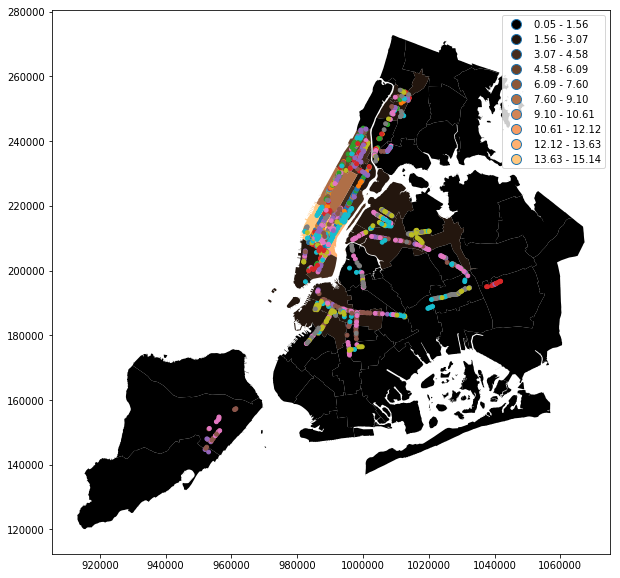

In [227]:
f, ax = plt.subplots(figsize=(10,10))

base = final_merge.plot(ax=ax, column = 'linkNYCp100p', k=10, scheme='equal_interval', legend=True, cmap='copper')
linkNYC_ft.plot(ax=ax, markersize=15, column = 'date_link_')

print("\nTitle: LinkNYC Stations over Number of Stations per 100ppl")

__Figure 4: The basemap in this plot is a cloropleth of the number of LinkNYC stations per 100 persons, split into 10 equal intervals. On top, we've plotted the locations of LinkNYC stations, color coded by how long ago each was installed. If we look back at Figure 3, we can see that there are PUMA regions in the Bronx and in Brooklyn with comparatively lower rates of household broadband access. These areas also have low numbers of LinkNYC stations per 100 people, suggesting that the LinkNYC efforts are not necessarily supplying internet where it's needed, but rather where people already have good access to broadband internet.__